## Importing all the necessary libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from tqdm import tqdm
from statistics import mean
import pandas as pd


In [5]:
# pytorch packages
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [6]:
# TO enable GPU. GO to runtime and change runtime type  to 'GPU'. if cuda the GPU is used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu available")
# device = 'cpu'
print(device)

cuda


In [ ]:
#!unzip FaceMaskDataset.zip -d dataset
# !unzip small.zip -d small
# !unzip small/Validation/Validation.zip -d temp

## Load the Data, Data pre-processing and Data Augmentation

1.   Normalization of all train, test, and validation dataset
2.   Augmentation of Train dataset only.

  1.   rescale all the image to 28x28
  2.   rotate, crop, shear the immage





In [7]:
# training_path = 'dataset/Train'
# valid_path = 'dataset/Validation'
# test_path = 'dataset/Test'

data_dir = 'dataset'
# data_dir = 'small'

In [8]:
# def preprocessing(path, type):
#   # Normalize a tensor image with mean and standard deviation.
#   # output[channel] = (input[channel] - mean[channel]) / std[channel]
#   normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#   transform = None
#   if type == "train":
#     transform = transforms.Compose([transforms.Resize((28,28)),transforms.RandomRotation(30),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(), normalize])
#     return datasets.ImageFolder(path, transform = transform)
#   else:
#     transform = transforms.Compose([transforms.Resize((28,28)),
#             transforms.ToTensor(),normalize])
#   return transform  

# def dataload(path, type):
#   """
#   """
#   return torch.utils.data.DataLoader(
#       datasets.ImageFolder(training_path, preprocessing(path, type)),
#       batch_size=24,
#       shuffle=True,
#       num_workers=2)  

# # use this to load the data in batch of 24 
# training_dataloader = dataload(training_path,"train")
# validation_dataloader = dataload(valid_path, "valid")
# testing_dataloader = dataload(test_path,"test")

# REF: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Just normalization for validation
#### Bikash Transformation
# data_transforms = {
#     'Train': transforms.Compose([
#         transforms.Resize(28),
#         transforms.RandomRotation(30),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'Validation': transforms.Compose([
#         transforms.Resize(28),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'Test': transforms.Compose([
#         transforms.Resize(28),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

#### Somaye Transformation
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in tqdm(['Train', 'Validation', 'Test'])}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=2)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Validation', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in tqdm(['Train', 'Validation', 'Test'])}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


inputs, classes = next(iter(dataloaders['Train']))
print(inputs.shape)
print(class_names)


100%|██████████| 3/3 [00:00<00:00, 3726.06it/s]


torch.Size([4, 3, 224, 224])
['NonHuman', 'WithMask', 'WithoutMask']


100%|██████████| 2/2 [00:00<00:00, 10381.94it/s]


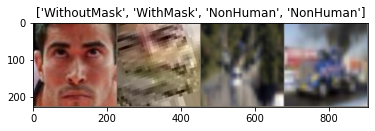

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = tqdm(next(iter(dataloaders['Train'])))

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train(train_loader, model, optimizer):
    losses = []
    accs = []
    output_labels = np.array([])

    model.train()

    for i, (images, target) in enumerate(tqdm(train_loader,position=0, leave=True)):
        images, target = images.to(device), target.to(device)

        # compute output
        optimizer.zero_grad()

        output = model(images)
        prediction = output.argmax(1)
        output_labels = np.append(output_labels, prediction.cpu().detach().numpy())
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        acc = accuracy(output, target)

        # compute gradient and do SGD step
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        losses.append(loss.item())
        accs.append(acc.item())

   # return losses, accs
    return losses, accs, output_labels

In [19]:
def test(test_loader, model, optimizer):
    losses = []
    accs = []
    accs_plot = []
    losses_plot = []
    output_labels = np.array([])
    test_labels = np.array([])
    
    model.eval()
    
    for i, (images, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
 
        images, target = images.to(device), target.to(device)
        test_labels = np.append(test_labels, target.cpu().detach().numpy())

        # compute output
        output = model(images)
        prediction = output.argmax(1)
        output_labels = np.append(output_labels, prediction.cpu().detach().numpy())
        # loss = criterion(output, target)
        
        # measure accuracy and record loss
        loss = torch.nn.functional.cross_entropy(output, target)
        
        acc = accuracy(output, target)
        losses.append(loss.item())
        accs.append(acc.item())
        if i%50 == 0:
            accs_plot.append(acc.item())
            losses_plot.append(loss.item())

    return losses, accs, output_labels, accs_plot, losses_plot, test_labels
    # return losses, accs
      

AlexNet Model

In [20]:
import torch
import torch.nn as nn
lr = 0.01
num_epochs = 4
criterion = nn.CrossEntropyLoss()

def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()


model_alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
model_alexnet = model_alexnet.to(device)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [21]:
optimizer = torch.optim.SGD(model_alexnet.parameters(), lr=lr)
predicted_labels_train_alex = []
predicted_labels_test_alex = []

for epoch in tqdm(range(0, num_epochs)):

        # train phase
        print("\n epoch: ",epoch+1,"\n Train Phase")

        losses, accs, predicted_labels_train_alex = train(dataloaders['Train'], model_alexnet, optimizer)
        # print("   losses",losses)
        print("   mean of losses:", mean(losses))
        # print("   accs",accs)
        print("   mean of accuracies:", mean(accs))
        
# test phase
print("\nTest Phase")
losses_alex, accs_alex, predicted_labels_test_alex, accs_plot_alex, losses_plot_alex, test_labels_alex = test(dataloaders['Test'], model_alexnet, optimizer)
Accuracy_alex = str(round(mean(accs_alex)*100, 2))
# print("   losses",losses_alex)
print("   mean of losses:", mean(losses_alex))
# print("   accs",accs_alex)
print("   mean of accuracies:", mean(accs_alex))

  0%|          | 0/3750 [00:00<?, ?it/s]


 epoch:  1 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]

   mean of losses: 0.4862161030582419
   mean of accuracies: 0.8537333333333333

 epoch:  2 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]

   mean of losses: 0.086427903307687
   mean of accuracies: 0.9716666666666667

 epoch:  3 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]

   mean of losses: 0.05766208748325109
   mean of accuracies: 0.9810666666666666

 epoch:  4 
 Train Phase


  0%|          | 0/373 [00:00<?, ?it/s]

   mean of losses: 0.041022413087120506
   mean of accuracies: 0.9874

Test Phase


100%|██████████| 373/373 [00:05<00:00, 70.88it/s]

   mean of losses: 0.06647244122497206
   mean of accuracies: 0.9772117962466488


Model

In [22]:
class block(nn.Module):
    def __init__(self, filters, subsample = False):
        super().__init__()
        
        s = 0.5 if subsample else 1.0

        # layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # shortcut connection
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            z = z + torch.cat((d, p), dim=1)
        else:
            z = z + x 

        z = self.relu2(z)
        
        return z



class myModel(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        # first layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # blocks
        self.block1 = nn.ModuleList([block(64, subsample=False) for _ in range(n)])

        self.block21 = block(128, subsample=True)
        self.block22 = nn.ModuleList([block(128, subsample=False) for _ in range(n-1)])

        self.block31 = block(256, subsample=True)
        self.block32 = nn.ModuleList([block(256, subsample=False) for _ in range(n-1)])
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.softmax = nn.LogSoftmax(dim=-1)

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 , 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )

        
        # initilise weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu(z)

        for l in self.block1: z = l(z)

        z = self.block21(z)
        for l in self.block22: 
            z = l(z)

        z = self.block31(z)
        for l in self.block32: 
            z = l(z)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.classifier(z)
        return self.softmax(z)

In [23]:

my_model = myModel(2)
my_model = my_model.to(device)


In [24]:
lr = 0.01
num_epochs = 4
optimizer = torch.optim.SGD(my_model.parameters(), lr=lr)
predicted_labels_train = []
predicted_labels_test = []
for epoch in tqdm(range(0, num_epochs),position=0, leave=True):

        # train phase
        print("\n\n epoch: ",epoch+1,"\n Train Phase")

        # losses, accs, predicted_labels = train(dataloaders['Train'], model_alexnet, optimizer)
        losses, accs, predicted_labels_train = train(dataloaders['Train'], my_model, optimizer)
        # print("   losses",losses)
        print("\n   mean of losses:", mean(losses))
        # print("   accs",accs)
        print("\n   mean of accuracies:", mean(accs))

# test phase
print("\nTest Phase")
losses_model, accs_model, predicted_labels_test, accs_plot_model, losses_plot_model, test_labels  = test(dataloaders['Test'], my_model, optimizer)
Accuracy_model = str(round(mean(accs_model)*100, 2))
# print("   losses",losses)
print("\n   mean of losses:", mean(losses_model))
# print("   accs",accs)
print("\n   mean of accuracies:", mean(accs_model))

  0%|          | 0/3750 [00:00<?, ?it/s]



 epoch:  1 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]


   mean of losses: 0.5225382066967276

   mean of accuracies: 0.8098666666666666


 epoch:  2 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]


   mean of losses: 0.22486316704582035

   mean of accuracies: 0.9157333333333333


 epoch:  3 
 Train Phase


  0%|          | 0/3750 [00:00<?, ?it/s]


   mean of losses: 0.15052560499150422

   mean of accuracies: 0.9458666666666666


 epoch:  4 
 Train Phase


  0%|          | 0/373 [00:00<?, ?it/s]


   mean of losses: 0.11191752028072854

   mean of accuracies: 0.9605333333333334

Test Phase


100%|██████████| 373/373 [00:09<00:00, 39.89it/s]


   mean of losses: 0.12851400249881886

   mean of accuracies: 0.9584450402144772


# **Evaluation**
Evaluatig the model in terms of accuracy, precision, recall and F1-measure

Getting Train and Test True Labels


In [25]:
# Train True Labels
train_labels = np.array([])
for data,target in dataloaders['Train']:
    train_labels = np.append(train_labels, target.detach().numpy())

print("Shape of train labels: " + str(train_labels.shape))
print("Shape of train predicted labels: " + str(predicted_labels_train.shape))
print("Shape of train predicted labels of AlexNet: " + str(predicted_labels_train_alex.shape))

# Test True Labels
#test_labels = np.array([])
#for data,target in dataloaders['Test']:
#    test_labels = np.append(test_labels, target.detach().numpy())
print("Shape of test labels: " + str(test_labels.shape))
print("Shape of test predicted labels: " + str(predicted_labels_test.shape))
print("Shape of test predicted labels of AlexNet: " + str(predicted_labels_test_alex.shape))


Shape of train labels: (15000,)
Shape of train predicted labels: (15000,)
Shape of train predicted labels of AlexNet: (15000,)
Shape of test labels: (1492,)
Shape of test predicted labels: (1492,)
Shape of test predicted labels of AlexNet: (1492,)


### **Visulaizing accuracy and loss**

Text(0, 0.5, 'accuracy')

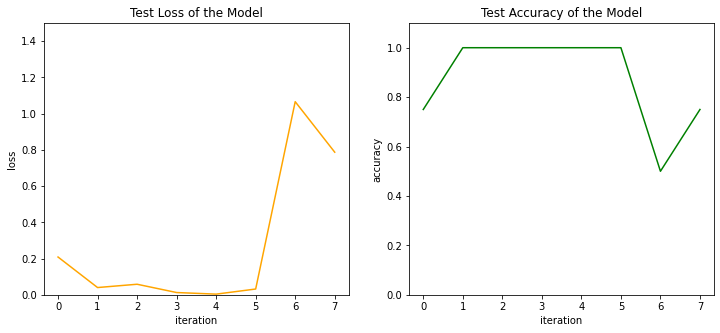

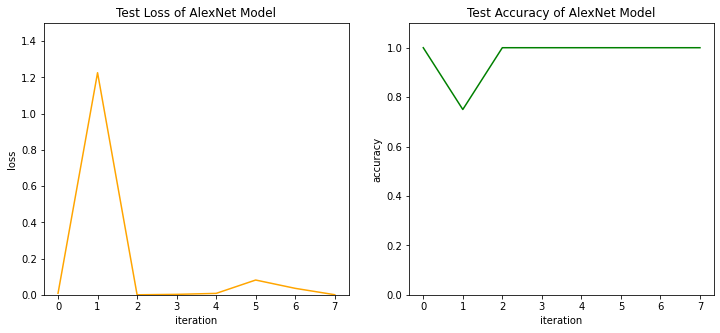

In [35]:
# our Model
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_ylim([0, 1.5])
axs[0].plot(losses_plot_model, color='orange')
axs[0].set_title('Test Loss of the Model')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].set_ylim([0, 1.1])
axs[1].plot(accs_plot_model, color='green')
axs[1].set_title('Test Accuracy of the Model')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

# AlexNet Model
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_ylim([0, 1.5])
axs[0].plot(losses_plot_alex, color='orange')
axs[0].set_title('Test Loss of AlexNet Model')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].set_ylim([0, 1.1])
axs[1].plot(accs_plot_alex, color='green')
axs[1].set_title('Test Accuracy of AlexNet Model')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

### **Confusion Matrix** 

''

<Figure size 1080x864 with 0 Axes>

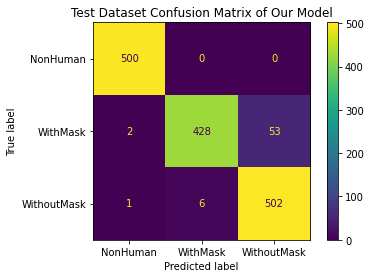

<Figure size 1080x864 with 0 Axes>

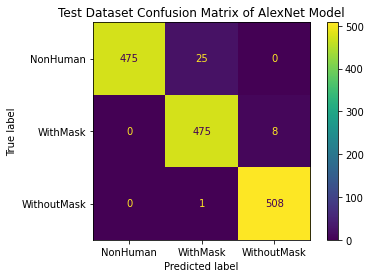

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

"""
plt.figure(figsize=(15,12))
cnf_train = confusion_matrix(train_labels, predicted_labels_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cnf_train, display_labels=class_names)
disp_train.plot() 
plt.title("Train Dataset Confusion Matrix")
"""

plt.figure(figsize=(15,12))
cnf_test = confusion_matrix(test_labels, predicted_labels_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cnf_test, display_labels=class_names)
disp_test.plot(values_format='') 
plt.title("Test Dataset Confusion Matrix of Our Model")

plt.figure(figsize=(15,12))
cnf_test_alex = confusion_matrix(test_labels_alex, predicted_labels_test_alex)
disp_test_alex = ConfusionMatrixDisplay(confusion_matrix=cnf_test_alex, display_labels=class_names)
disp_test_alex.plot(values_format='') 
plt.title("Test Dataset Confusion Matrix of AlexNet Model")

;

### **Precision and Recall**

In [28]:
from sklearn.metrics import precision_score, recall_score

ytest = test_labels
ytest_alex = test_labels_alex
ypred = predicted_labels_test
ypred_alex = predicted_labels_test_alex

# precision of our model
precision_micro = precision_score(ytest, ypred, average='micro')
precision_macro = precision_score(ytest, ypred, average='macro')

# recall of our model
recall_micro = recall_score(ytest, ypred, average='micro')
recall_macro = recall_score(ytest, ypred, average='macro')

# precision of AlexNet model
precision_micro_alex = precision_score(ytest_alex, ypred_alex, average='micro')
precision_macro_alex = precision_score(ytest_alex, ypred_alex, average='macro')

# recall of AlexNet model
recall_micro_alex = recall_score(ytest_alex, ypred_alex, average='micro')
recall_macro_alex = recall_score(ytest_alex, ypred_alex, average='macro')

print("------------------ Our Model ----------------")
print("Precision Micro = " + str(round(precision_micro*100, 2)) + "%")
print("Precision Macro = " + str(round(precision_macro*100, 2))+ "%")
print("Recall Micro = " + str(round(recall_micro*100, 2))+ "%")
print("Recall Macro = " + str(round(recall_macro*100, 2))+ "%")

print("------------------ AlexNet Model ----------------")
print("Precision Micro = " + str(round(precision_micro_alex*100, 2)) + "%")
print("Precision Macro = " + str(round(precision_macro_alex*100, 2))+ "%")
print("Recall Micro = " + str(round(recall_micro_alex*100, 2))+ "%")
print("Recall Macro = " + str(round(recall_macro_alex*100, 2))+ "%")

------------------ Our Model ----------------
Precision Micro = 95.84%
Precision Macro = 96.16%
Recall Micro = 95.84%
Recall Macro = 95.75%
------------------ AlexNet Model ----------------
Precision Micro = 97.72%
Precision Macro = 97.75%
Recall Micro = 97.72%
Recall Macro = 97.72%


### **F1 Score**

In [30]:
from sklearn.metrics import f1_score

ytest = test_labels
ytest_alex = test_labels_alex
ypred = predicted_labels_test
ypred_alex = predicted_labels_test_alex

# F1 Score of our model
f1_micro = f1_score(ytest, ypred, average='micro')
f1_macro = f1_score(ytest, ypred, average='macro')

# F1 Score of AlexNet model
f1_micro_alex = f1_score(ytest_alex, ypred_alex, average='micro')
f1_macro_alex = f1_score(ytest_alex, ypred_alex, average='macro')

print("------------------ Our Model ----------------")
print("F1 Score Micro = " + str(round(f1_micro*100, 2))+ "%")
print("F1 Score Macro = " + str(round(f1_macro*100, 2))+ "%")

print("------------------ AlexNet Model ----------------")
print("F1 Score Micro = " + str(round(f1_micro_alex*100, 2))+ "%")
print("F1 Score Macro = " + str(round(f1_macro_alex*100, 2))+ "%")

------------------ Our Model ----------------
F1 Score Micro = 95.84%
F1 Score Macro = 95.8%
------------------ AlexNet Model ----------------
F1 Score Micro = 97.72%
F1 Score Macro = 97.7%


### **Overview of the results**

In [31]:
pd_data = {'Model': [], 
           'Accuracy': [], 
           'Precision_micro': [], 
           'Precision_macro': [], 
           'Recall_micro': [], 
           'Recall_macro': [],
           'F1_micro': [], 
           'F1_macro': []}
df = pd.DataFrame(pd_data)

new_row1 = {'Model': 'MyModel', 
           'Accuracy':Accuracy_model, 
           'Precision_micro':precision_micro, 
           'Precision_macro':precision_macro, 
           'Recall_micro':recall_micro, 
           'Recall_macro':recall_macro,
           'F1_micro': f1_micro, 
           'F1_macro': f1_macro}


new_row2 = {'Model': 'AlexNet', 
           'Accuracy':Accuracy_alex, 
           'Precision_micro':precision_micro_alex, 
           'Precision_macro':precision_macro_alex, 
           'Recall_micro':recall_micro_alex, 
           'Recall_macro':recall_macro_alex,
           'F1_micro': f1_micro_alex, 
           'F1_macro': f1_macro_alex}

df = df.append(new_row1, ignore_index=True)           
df = df.append(new_row2, ignore_index=True)
df

,Model,Accuracy,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,MyModel,95.84,0.958445,0.961572,0.958445,0.957459,0.958445,0.958032
1,AlexNet,97.72,0.977212,0.977533,0.977212,0.977157,0.977212,0.977009


## **Save and Load of the trained model**

In [63]:
# save model
"""
PATH = "SavedModel.pt"
torch.save(my_model.state_dict(), PATH)
"""

In [65]:
"""
new_model = myModel(2)
new_model = new_model.to(device)


new_model.load_state_dict(torch.load(PATH))
new_model.eval()


print("\nTest Phase")
losses_model_new, accs_model_new, predicted_labels_test_new, accs_plot_model_new, losses_plot_model_new, test_labels_new  = test(dataloaders['Test'], new_model, optimizer)
Accuracy_model_new = str(round(mean(accs_model_new)*100, 2))
# print("   losses",losses)
print("\n   mean of losses:", mean(losses_model_new))
# print("   accs",accs)
print("\n   mean of accuracies:", mean(accs_model_new))
"""

  0%|          | 0/373 [00:00<?, ?it/s]


Test Phase


100%|██████████| 373/373 [00:09<00:00, 39.62it/s]


   mean of losses: 0.12851400286480147

   mean of accuracies: 0.9584450402144772
